In [28]:
import pandas as pd
from surprise import SVDpp, Dataset, Reader, dump
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate


# Load the data
data = pd.read_csv('data_0.csv')

# #normalize
# data['score'] = data['score'].apply(normalize_data)

# Define the rating scale
reader = Reader(rating_scale=(0, 10))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(data[['user_id', 'item_id', 'score']], reader)

# Split data into train and test
trainset, testset = train_test_split(data, test_size=.25)


# Grid search

In [10]:
# param_grid = {
#     'n_factors': [50],
#     'n_epochs': [30],
#     'lr_all': [0.001],
#     'reg_all': [0.001]
# }
# gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=5)

# gs.fit(data)

# # best RMSE score
# print(gs.best_score['rmse'])
# # combination of parameters that gave the best RMSE score
# print(gs.best_params['rmse'])
#algo = SVDpp(n_factors = int(gs.best_params['rmse']['n_factors']),n_epochs = int(gs.best_params['rmse']['n_epochs']), lr_all = float(gs.best_params['rmse']['lr_all']), reg_all = float(gs.best_params['rmse']['reg_all']))

3.063943777403831
{'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.001, 'reg_all': 0.001}


# Make prediction

In [29]:
# Use the SVD++ algorithm.
algo = SVDpp(n_factors = 50,n_epochs = 30, lr_all = 0.001, reg_all = 0.001)

# Train the algorithm on the trainset
algo.fit(trainset)

# Save the model to a file
model_file = 'model_file.pkl'
dump.dump(model_file, algo=algo)

print("Model saved successfully.")

# Then predict ratings for all pairs (u, i) that are in the test set.
predictions = algo.test(testset)

results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Model saved successfully.
Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    3.0347  3.0128  3.0099  3.0124  3.0161  3.0172  0.0090  
MAE (testset)     2.6328  2.6141  2.6070  2.6104  2.6132  2.6155  0.0090  
Fit time          51.04   52.68   51.51   52.28   62.92   54.09   4.45    
Test time         2.22    2.31    2.15    2.10    3.98    2.55    0.72    


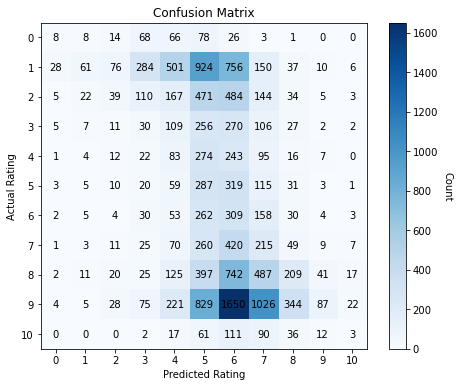

[[   8    8   14   68   66   78   26    3    1    0    0]
 [  28   61   76  284  501  924  756  150   37   10    6]
 [   5   22   39  110  167  471  484  144   34    5    3]
 [   5    7   11   30  109  256  270  106   27    2    2]
 [   1    4   12   22   83  274  243   95   16    7    0]
 [   3    5   10   20   59  287  319  115   31    3    1]
 [   2    5    4   30   53  262  309  158   30    4    3]
 [   1    3   11   25   70  260  420  215   49    9    7]
 [   2   11   20   25  125  397  742  487  209   41   17]
 [   4    5   28   75  221  829 1650 1026  344   87   22]
 [   0    0    0    2   17   61  111   90   36   12    3]]
RMSE:  3.0171872195912197
MAE:  2.6154810252691014


In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Create the confusion matrix (same code as before)
matrix_size = 11
confusion_matrix = np.zeros((matrix_size, matrix_size), dtype=int)
for pred in predictions:
    predicted_rating = round(pred.est)
    actual_rating = int(pred.r_ui)
    confusion_matrix[actual_rating, predicted_rating] += 1

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Create the heatmap
im = ax.imshow(confusion_matrix, cmap='Blues')

# Set the axis labels
ax.set_xticks(np.arange(matrix_size))
ax.set_yticks(np.arange(matrix_size))
ax.set_xticklabels(np.arange(matrix_size))
ax.set_yticklabels(np.arange(matrix_size))
ax.set_xlabel('Predicted Rating')
ax.set_ylabel('Actual Rating')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set the colorbar label
cbar.ax.set_ylabel('Count', rotation=-90, va="bottom")

# Loop over the data and add text annotations
for i in range(matrix_size):
    for j in range(matrix_size):
        text = ax.text(j, i, confusion_matrix[i, j],
                       ha="center", va="center", color="black")

# Set the title
ax.set_title("Confusion Matrix")

# Show the plot
plt.show()

print(confusion_matrix)
print("RMSE: ", results['test_rmse'].mean())
print("MAE: ", results['test_mae'].mean())


#none
# RMSE:  3.0198620876184674
# MAE:  2.615229108761728

#10
#RMSE:  3.0557443712330845
#MAE:  2.634426294597527

#60
# RMSE:  3.0962216908622806
# MAE:  2.631240220885894

#100
# RMSE:  3.0870862763517435
# MAE:  2.616656534743417



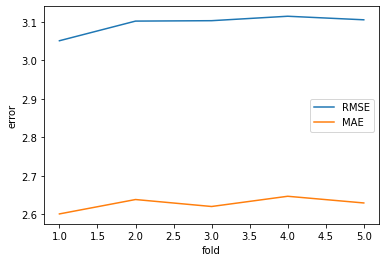

In [35]:
#plot the results with labels
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.plot(np.arange(1, 6), results['test_rmse'], label='RMSE')
ax.plot(np.arange(1, 6), results['test_mae'], label='MAE')
ax.set_xlabel('fold')
ax.set_ylabel('error')
ax.legend()
plt.show()


In [63]:
from collections import defaultdict

loaded_model = dump.load(model_file)[1]

def get_n(predictions, n=10, order=1):
    """Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
        order(int): 0 for ascending order, 1 for descending order
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        # if est > 0:
        top_n[uid].append((iid, est))

    if(order):
        # Then sort the predictions for each user and retrieve the k highest ones.
        for uid, user_ratings in top_n.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_n[uid] = user_ratings[:n]
    else:
        # Then sort the predictions for each user and retrieve the k lowest ones.
        for uid, user_ratings in top_n.items():
            user_ratings.sort(key=lambda x: x[1])
            top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_n(predictions, n=10, order=1)
lowest_n = get_n(predictions, n=10, order=0)

# Print the recommended items for each user

print(top_n['white'])
print(lowest_n)

[('8ysjQYvgyCc', 10), ('Rn_kLtLnKts', 10), ('iW0LiIMYqrU', 10), ('GuTgfnkILGs', 10), ('sDPk-r18sb0', 9.910300076725909), ('RilwnjDwTOc', 9.876150829555707), ('urhVbud_vMc', 9.543393300154115), ('lYXQvHhfKuM', 9.472391755195119), ('iiKuUElvGhM', 9.368631739800628), ('hdAEGAwlK0M', 9.34279895925304)]
defaultdict(<class 'list'>, {'bastianlouis': [('DAVNU3pshVM', 2.80055594880013), ('jg3gG1X8L08', 2.8444549666000256), ('Y5VSvL8VGpE', 2.894316590720202), ('OpOcGoGRslQ', 3.0067511509351084), ('zygtkJfNkJg', 3.182527680232652), ('NFdENyYiJzw', 3.3417425231406304), ('vFRt5qK74wM', 3.3939294300023533), ('7OPg-ksxZ4Y', 3.4706788527462145), ('Nv1_Gf92WKc', 3.571841568880032), ('XwOB7gXnuTk', 3.8103929550689752)], 'beu': [('p37NsAeNivI', 7.434547235894286), ('3cb38Wv8Ahw', 7.573220042061361), ('bNEjzjeSHgI', 7.623535840114771), ('jRNs4eGl-Rs', 7.629892584963085), ('vWcdqPn8Ch8', 7.7517201807160365), ('MooO7bRm8Jo', 7.829427781650119), ('xpUIZ32n9nw', 7.842011502419742), ('XhlvLJ4daZ4', 7.860841875

In [4]:
import pandas as pd
from surprise import SVDpp, Dataset, Reader, dump
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate
import numpy as np

model_file = 'model_file.pkl'
loaded_model = dump.load(model_file)[1]
# Load the data
data = pd.read_csv('data_60.csv')

# #normalize
# data['score'] = data['score'].apply(normalize_data)

# Define the rating scale
reader = Reader(rating_scale=(0, 10))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(data[['user_id', 'item_id', 'score']], reader)

def get_unrated_items(user_id, df):
    """Return the unrated items for a given user
    Args:
        user_id: the user_id of the user
        df: the dataframe with all the ratings
    Returns:
        A list of items that the user has not rated yet
    """
    df = pd.DataFrame(data.raw_ratings, columns=['user_id', 'item_id', 'rating', 'timestamp'])
    rated_items = df[df['user_id'] == user_id]['item_id'].tolist()
    unrated_items = df[~df['item_id'].isin(rated_items)]['item_id'].tolist()
    return unrated_items

def predict_ratings(user_id, algo):
    """Return the predicted ratings for a given user and the unrated items
    Args:
        user_id: the user_id of the user
        unrated_items: the unrated items for the user
        algo: the algorithm used to predict the ratings
    Returns:
        A list of tuples (item_id, predicted_rating) for the user
    """
    predicted_ratings = []
    unrated_items = get_unrated_items(username, data)
    unrated_items = np.random.choice(unrated_items, 10, replace=False)
    for item_id in unrated_items:
        predicted_ratings.append((item_id, algo.predict(user_id, item_id).est))
    return predicted_ratings

username = 'white'

predicted_ratings = predict_ratings(username, loaded_model)

def convert_score(score):
    # Define the old and new rating scale
    old_min, old_max = 0, 10
    new_min, new_max = -100, 100
    return round((score - old_min) / (old_max - old_min) * (new_max - new_min) + new_min)

transformed_scores = [(item_id, convert_score(score)) for item_id, score in predicted_ratings]
print(transformed_scores)

[('-Z4MkwoNi4o', -27), ('vWcdqPn8Ch8', -6), ('VW8i6V0ntRg', 10), ('PSnSo9kYlH4', -3), ('nyGrd6w65Ao', 54), ('z2kuC7w9emE', -34), ('aG32cKPQfP4', 3), ('w9J6D4r30HY', 29), ('pM50tycTqeY', -48), ('cjElJ4P-sKM', -92)]


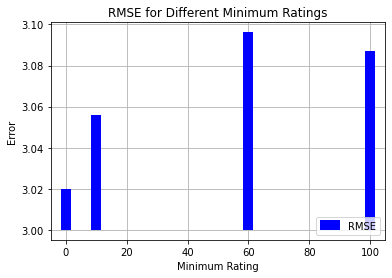

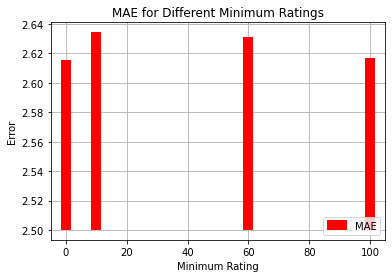

In [35]:
import matplotlib.pyplot as plt
x = [0, 10, 60, 100]
rmse = [3.0198620876184674, 3.0557443712330845, 3.0962216908622806, 3.0870862763517435]
mae = [2.615229108761728, 2.634426294597527, 2.631240220885894, 2.616656534743417]

plt.vlines(x, 3, rmse, colors='blue', linewidth=10, label='RMSE')
plt.xlabel('Minimum Rating')
plt.ylabel('Error')
plt.title('RMSE for Different Minimum Ratings')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

plt.vlines(x, 2.5, mae, colors='red', linewidth=10, label='MAE')
plt.xlabel('Minimum Rating')
plt.ylabel('Error')
plt.title('MAE for Different Minimum Ratings')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()